# Интро

Целью данного проекта является построение генератора на основе FASHION MNIST датасета 

Генератор будет брать в себя рандомные значения. Обычно название для этого - латентное измерение. 


К примеру [1, 23, 42, 71]. Генератор будет брать эти значения и на аутпуте выдывать значения, которые представляют из себя изображения.


FASHION MNIST DATASET включается в сетбя 28 * 28 * 1 значений. 28 строк по 28 колонок для 1 цвета. 


В генератор в данном случае будем брать 128 значений.


В генеторе будет присутствовать некоторое значение сверточных слоев и upsampling слоев, которые в конечном итоге будут выдавать изображение в формате 28 * 28 * 1.


Сгенерированное изображение будет поступать на вход в дискриминатор, который будет состоять из некоторого значения сверточных слоев, но финальный аутпут для дискриминатора будет [0, 1] (False or True), что представляет из себя проверку настоящее ли изображение было сгенерировано или нет.


В тоже самое время на вход в сверточный слой дискриминатора будут поступать реальные изображения из FASHION MNIST, чтобы мы смогли натренировать дискриминатор, чтобы он мог понять что является настоящим изображением, а что нет. 


По большему счету нам нужен баланс между генератором и дискриминатором. Мы запустим тренировочный луп, который будет "награждать" дискриминатор, если он будет правильно угадывать ненастощие изображения, и который будет награждать генератор, если он сможет "обмануть" дискриминатор.


С помощью keras и tensorflow мы сможем создать кастомный тренировочный луп.

# Установка окружения

In [102]:
# #Подключение tensorflow-gpu
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [103]:
#не дает модели использовать более 0.333 оперативки, помогает если надо обучать несколько моделей сразу (к примеру, когда
#мы учили несколько моделей сразу играть в игру)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [104]:
import tensorflow_datasets as tfds #fashion mnist dataset
from matplotlib import pyplot as plt #для визуализации датасета

In [105]:
ds = tfds.load('fashion_mnist', split='train') #берем датасет

# Визуализация данных и создание пайплайна по предобработке данных

In [106]:
import numpy as np #для трансормации данных

Перейдем к созданию итератора

In [107]:
#Инициализируем итератор
dataiterator = ds.as_numpy_iterator()

In [108]:
dataiterator.next()['image'] #смотрим данные из датасета

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

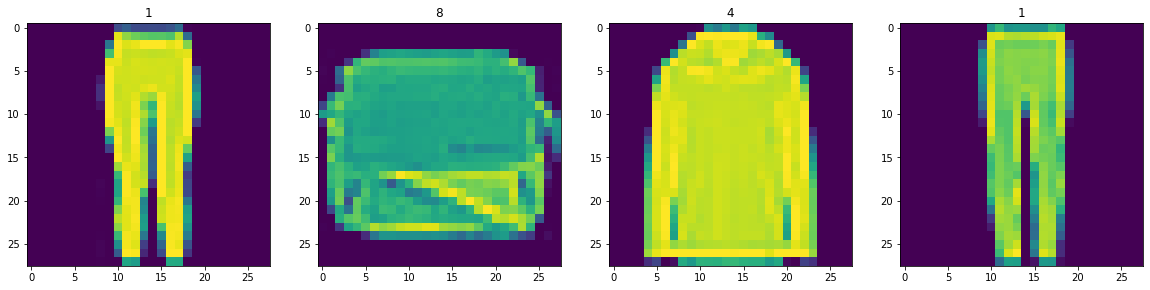

In [109]:
# Создаем подучастки для показа изображений  
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #в участке будет всего 4 колонки
# Делаем луп через 4 айтема и получаем изображения 
for idx in range(4): 
    # Берем изображение и его лейбл
    sample = dataiterator.next()
    # Строим изображение 
    #берем из sample (словаря) ключ image. np.squeeze превращает sample.shape 28*28*1 в 28*28
    ax[idx].imshow(np.squeeze(sample['image'])) #один столбец включает в себя изображение
    # Добавляем лейбл в ax
    ax[idx].title.set_text(sample['label'])

In [110]:
# Масштабируем изображения 
def scale_images(data): 
    image = data['image']
    return image / 255

In [111]:
#Создаем пайплайн для обработки данных
# Перезугружаем датасет, чтобы все было в одной ячейке
ds = tfds.load('fashion_mnist', split='train')
# Масштабируем все изображения
ds = ds.map(scale_images) 
# Кэшируем датасет
#При первом повторении датасета его элементы будут кэшированы
#либо в указанном файле, либо в памяти. Последующие итерации будут
#использовать кешированные данные.
#Данный шаг снижает нагружку на память
ds = ds.cache()
# Перемешиваем сэмплы по всей длине датасета
ds = ds.shuffle(60000)
# Батч будет размером в 128 сэмплов
ds = ds.batch(128)
# За счет использования доп. позволяет подготовить последующие элементы датасета, пока обрабатывается текущий.
ds = ds.prefetch(64)

In [112]:
ds.as_numpy_iterator().next().shape
#128 сэпмлов в батче, 28 строк * 28 колонок с 1 цветом

(128, 28, 28, 1)

# Построение модели нейронной сети

В данном проекте мы не используем conditional gen, который дает больше контроля над ситуацией генерирования.

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [157]:
#Приступим к созданию генератора
def build_generator(): 
    model = Sequential()
    
    # На вход принимается 128 рандомных значений, чтобы помочь генератору понять что генерировать
    # В данном типе модели мы не отвечаем за то, что именно генерируем. Здесь на основе всего датасета генерируюся
    # рандомные изображения
    # Чтобы повысить качество, а не просто оставаться на 128 значениях, мы изменяем форму входного аррэя на 7*7*128
    model.add(Dense(7*7*128, input_dim=128))
    #Функция активации
    model.add(LeakyReLU(0.2)) #в отличии от ReLU, где для если x <= 0, y = 0, в LeakyReLU если x <= 0, то y = 0.01x
    # Конверируем в первоначальную форму изображения
    model.add(Reshape((7,7,128))) 
    
    #далее мы напрвляем построение модели на то, чтобы воспроизвести форму 28*28*1
    # Мы специально перевели в форму (7,7,128), т.к. мы хотим привести array к формату 28*28*1, а если 7*2 = 14, то 14*2 = 28
    #UpSampling2D() слой отвечает именно за это
    
    # Upsampling блок должен удваивать качество изображения
    model.add(UpSampling2D())
    #Теперь  форма (None, 14, 14, 128) 
    model.add(Conv2D(128, 5, padding='same'))
    #128 - количество юнитов, 5 - кол-во ядер, 
    model.add(LeakyReLU(0.2))
    
    # Второй upsampling блок
    model.add(UpSampling2D())
    #Теперь форма (None, 28, 28, 128) 
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Блок свертывания 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Блок свертывания 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Лэйер, чтобы выпустить изображение на выходе
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [158]:
generator = build_generator()

In [116]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

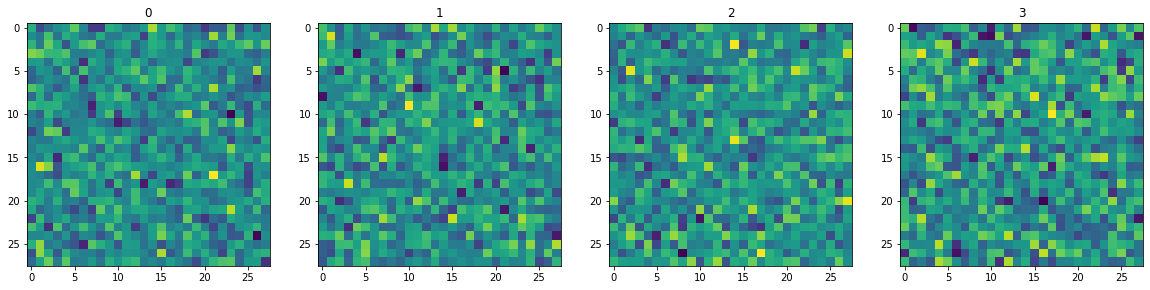

In [117]:
rand_img = np.random.randn(4, 28, 28 ,1)
#На основе прошлого кода визуализации визуализируем полученное изображение
# Создаем подучастки для показа изображений  
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #в участке будет всего 4 колонки
# Делаем луп через 4 айтема и получаем изображения 
for idx, img in enumerate(rand_img): 
    # Строим изображение 
    #берем из sample (словаря) ключ image. np.squeeze превращает sample.shape 28*28*1 в 28*28
    ax[idx].imshow(np.squeeze(img)) #один столбец включает в себя изображение
    # Добавляем лейбл в ax
    ax[idx].title.set_text(idx)

In [136]:
#протестируем генератор. На выходе мы должны получить изображение на основе рандомных значений
img = generator.predict(np.random.randn(4,128,1))
#4 сэмпла по 128 пикселей в 1 цветовом канале
#на основе данных 4 сэпмлов генератор построит похожие изображения
img.shape

1/1 [==============================] - 0s 40ms/step


(4, 28, 28, 1)

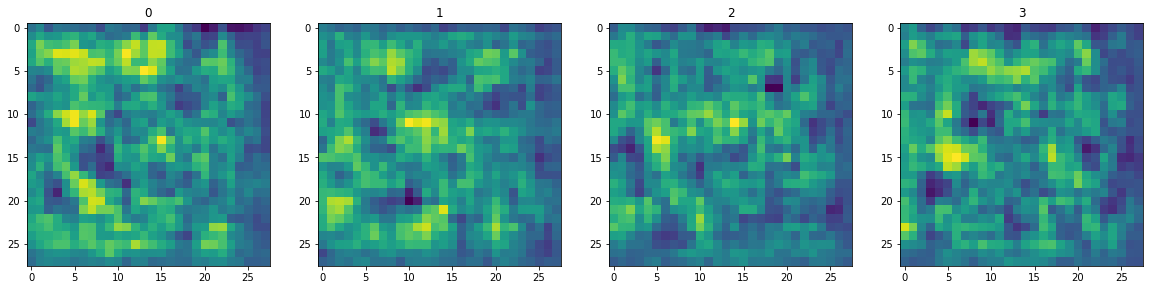

In [119]:
#На основе прошлого кода визуализации визуализируем полученное изображение
# Создаем подучастки для показа изображений  
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #в участке будет всего 4 колонки
# Делаем луп через 4 айтема и получаем изображения 
for idx, img in enumerate(img): 
    # Строим изображение 
    #берем из sample (словаря) ключ image. np.squeeze превращает sample.shape 28*28*1 в 28*28
    ax[idx].imshow(np.squeeze(img)) #один столбец включает в себя изображение
    # Добавляем лейбл в ax
    ax[idx].title.set_text(idx)

# Построение дискриминатора

In [120]:
def build_discriminator(): 
    model = Sequential()
    
    # Первый свертч. слой
    #в нем 32 "фильтра" (юнита), в котором окно размером 5*5
    #input_shape = output_shape генератора 
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) #повысили дроп аут, чтобы дискриминатору было сложнее учиться
    
    # Второй свертч. слой
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Третий свертч. слой
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Четвертый свертч. слой
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Переводим данные в 1-D и отправляем в аутпут
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [121]:
discriminator = build_discriminator()

In [122]:
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 128)      

In [137]:
img = img[0] #берем один сэмпл изображения из батча

In [138]:
img.shape

(28, 28, 1)

In [139]:
np.expand_dims(img, 0).shape

(1, 28, 28, 1)

In [140]:
discriminator.predict(np.expand_dims(img, 0)) #расширяем измерения, чтобы сэмпл был по форме батча

1/1 [==============================] - 0s 116ms/step


array([[0.4959197]], dtype=float32)

# Создание тренировочного цикла

Для начала инициализируем функцию потерь и оптимайзер

In [141]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [142]:
#g - для генератора
#d - для дискриминатора
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) #дискриминатор должен учиться медленее, чтобы генератор успевал учиться на одном уровне
#с дикриминатором, т.к. если дискриминатор будет "умнее" генератора, то он будет легче подмечать в каких местах
#генератор пытается "обмануть" диксриминатор
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Далее начнем создавать субклассовую модель

In [143]:
from tensorflow.keras.models import Model

In [160]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        
        # Создаем атрибуты для генератора и дискриминатора
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        
        # Атрибуты для фун. потерь и оптимайзера
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Берем данные
        # Напомним, что батч состоит из 128 сэпмлов 28*28
        real_images = batch
        #создаем рандомные изображения с помощью генератора
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Обучаем дискриминатор
        #Подключаем градиент к циклу
        with tf.GradientTape() as d_tape: 
            # Пропускаем реальные и сгенерированные изображения через дискриминатор
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Создаем лейблы для реальных и фейковых изображений
            #Лейбл для реальных изображений - 0, для фейковых - 1
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
                        # Добавляем немного шума для True значений
                #не обязательно умножать именно на 0.15 - просто такое значение показало себя лучше при обучении
                #tf.random.uniform создает нормальное распределение по форме yhat_
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Считаем функцию потерь для дискриминанта
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Применяем backpropagation - способ обучения нейронной сети с использованием антиградиента и chain rule
        #По большему счету мы стараемся найти такой градиент, который позволит дискриминатору лучше улавливать
        #изображения, которые сгенерировала модель, а за значение этого отвечает total_d_loss
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) #подсчет градиента
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)) #применение градиента
        
        # Обучение генератора
        with tf.GradientTape() as g_tape: 
            # Генерирование новых изображений 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Создаем лейблы для предикта
            #В общем, когда мы создавали лейблы для дискриминатор, то мы указали, что фейковых изображений
            #будет лейбл 1. Т.к. мы хотим "обмануть" наш дискриминатор, то мы поставим лейбл для фейковых изображений 0.
            #Сейчас мы хотим чтобы дискриминатор "подумал", что наши фейковые изображения - это настоящие изображения 
            
            #проводим сгенерированные изображения через дискриминатор
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Подсчет функции потерь 
            # Генератор получает вознаграждение каждый раз, когда диксриминатор думает, что фейковые изображение - реальные
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # backprop. по отношению к генератору
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [161]:
fashgan = FashionGAN(generator, discriminator)

In [162]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

Создадим колбэк, чтобы мониторить обучение модели

In [147]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [148]:
#позволяет сохрнаять примеры сгенерированных изображений во время тренировки модели
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        #num_img - сколько изображений нужно сгенерировать
        #latent_dim - насколько большим должно быть latent dimension - рандомные значения, которые поступают на вход в
        #генератор, чтобы сгенерировать рандомные изображения
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        #в конце каждой эпохи
        #создаем нормальное распределение для изображений
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1)) 
        #генерируем само изображение
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        #конвертируем в numpy
        generated_images.numpy()
        #в папке в которой работаешь, нужно создать папку 'images' в которой будут храниться сгенерированные в конце эпохи
        #изображения
        for i in range(self.num_img):
            #конвертируем изобр в аррэй
            img = array_to_img(generated_images[i])
            #сохраняем
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [149]:
# Наилучшим решением будет тренировать где-то до 2000 эпох, пока функции потерь не прекратят расти 
#hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor()])

In [150]:
# plt.suptitle('Loss')
# plt.plot(hist.history['d_loss'], label='d_loss')
# plt.plot(hist.history['g_loss'], label='g_loss')
# plt.legend()
# plt.show()

# Тестирование модели

In [164]:
#загрузим модель, которая уже произвела 2000 эпох
#model = tf.keras.models.load_model('toxicity.h5')
generator.load_weights('generatormodel.h5')

ValueError: axes don't match array

In [155]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 26ms/step


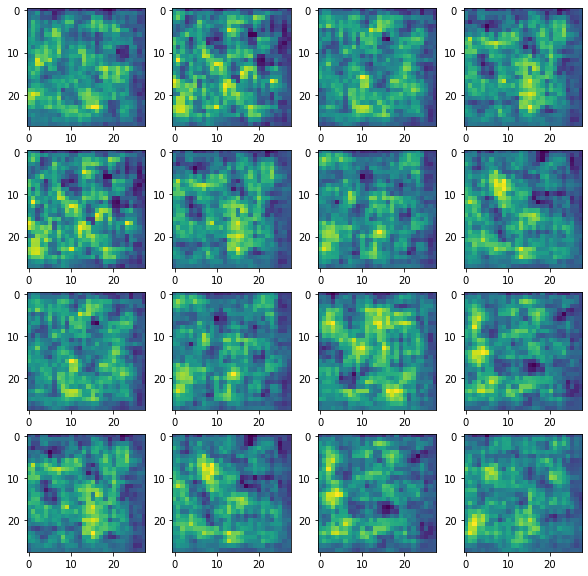

In [156]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])